# Data Loading

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew #for some statistics
from IPython.display import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting

In [2]:
# Importing and putting the dataset
data = pd.read_csv('input/train.csv')

In [3]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# Saving the 'Id' column
train_ID = data['Id']

# Drop the 'Id' colum since it's unnecessary for  the prediction process.
data.drop("Id", axis = 1, inplace = True)

# Data Processing

## Outliers

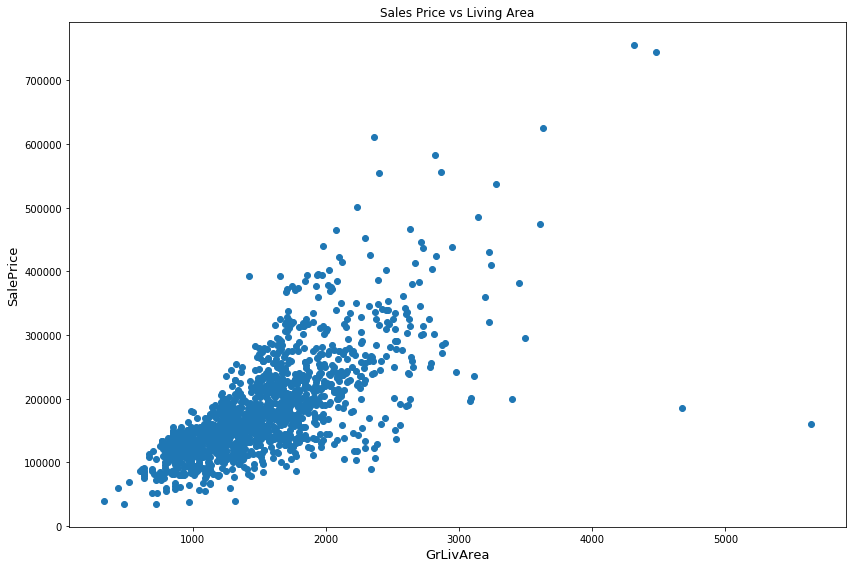

In [5]:
plt.figure(figsize=(12, 8))
plt.scatter(data['GrLivArea'], data['SalePrice'])
plt.title('Sales Price vs Living Area')
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.tight_layout()
plt.show()

We can see at the bottom right two with extremely large GrLivArea that are of a low price. These values are huge oultliers. Therefore, we can safely delete them.

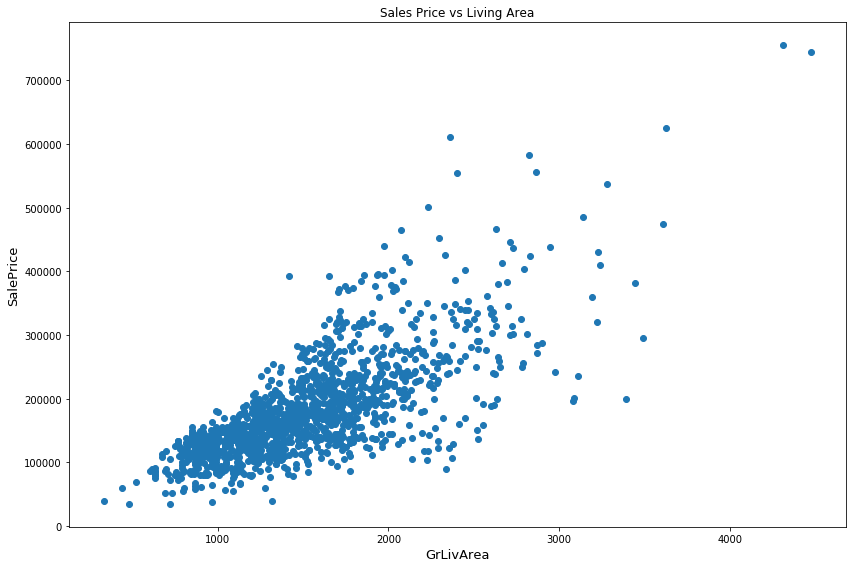

In [6]:
# Deleting outliers
data = data.drop(data[(data['GrLivArea'] > 4000) & (data['SalePrice'] < 300000)].index)

# Check the graphic again
plt.figure(figsize=(12, 8))
plt.scatter(data['GrLivArea'], data['SalePrice'])
plt.title('Sales Price vs Living Area')
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.tight_layout()
plt.show()

## Target Variable

In [7]:
# Descriptive statistics summary
data['SalePrice'].describe()

count      1458.000000
mean     180932.919067
std       79495.055285
min       34900.000000
25%      129925.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


 mu = 180932.92 and sigma = 79467.79



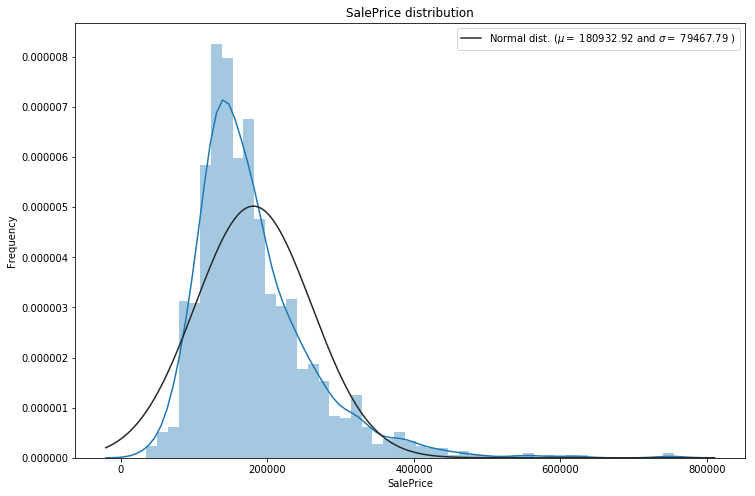

In [8]:
plt.figure(figsize=(12, 8))
sns.distplot(data['SalePrice'] , fit=norm);

(mu, sigma) = norm.fit(data['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
plt.show()

* Deviate from the normal distribution.
* Have appreciable positive skewness.
* Show peakedness.

In [9]:
print("Skewness: {:.2f}".format(data['SalePrice'].skew()))
print("Kurtosis: {:.2f}".format(data['SalePrice'].kurt()))

Skewness: 1.88
Kurtosis: 6.52



 mu = 12.02 and sigma = 0.40



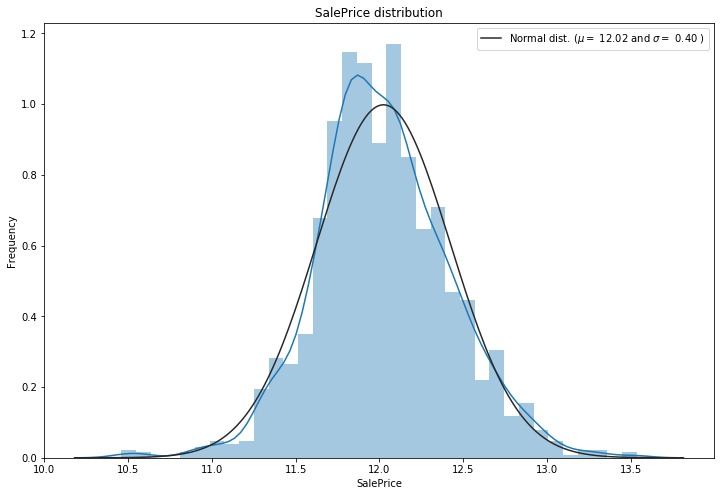

In [10]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
tmp_log = np.log1p(data["SalePrice"])

#Check the new distribution 
plt.figure(figsize=(12, 8))
sns.distplot(tmp_log , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(tmp_log)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
plt.show()

The skew seems now corrected and the data appears more normally distributed.

# Data Correlation

### Feature selection

To explore the correlation, we will start with some practical recipes to make sense of our data:

* Correlation matrix (heatmap).
* Correlation matrix (zoomed heatmap).
* Scatter plots between the most correlated variables.

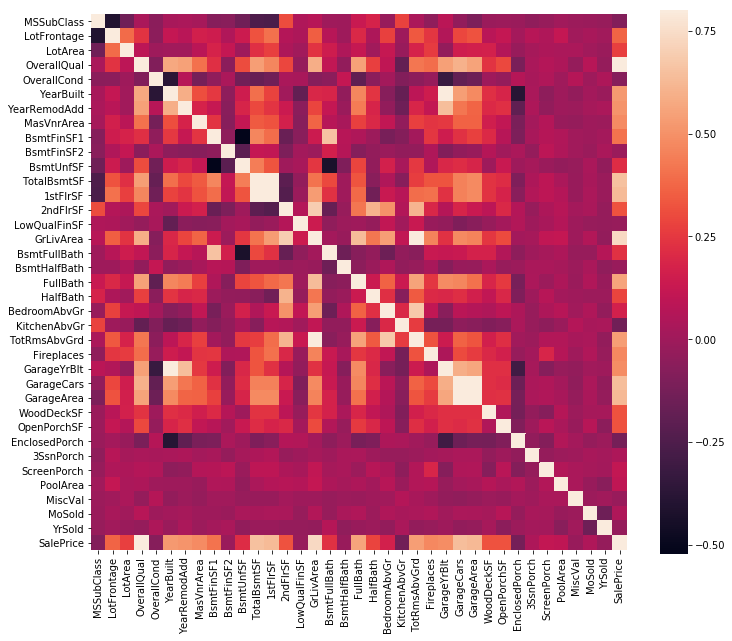

In [11]:
# Correlation matrix
corrmat = data.corr()
f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

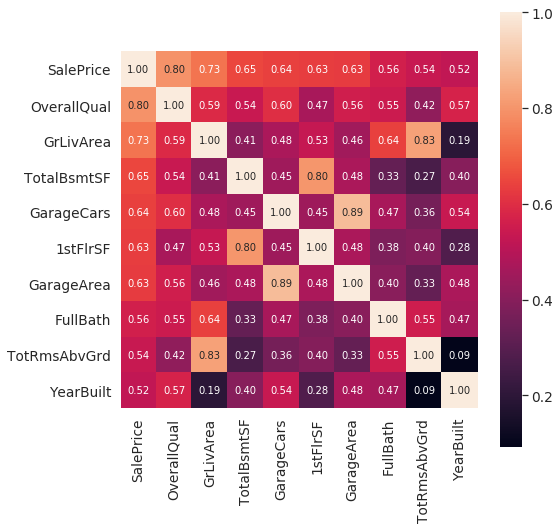

In [12]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(data[cols].values.T)
plt.figure(figsize=(8, 8))
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

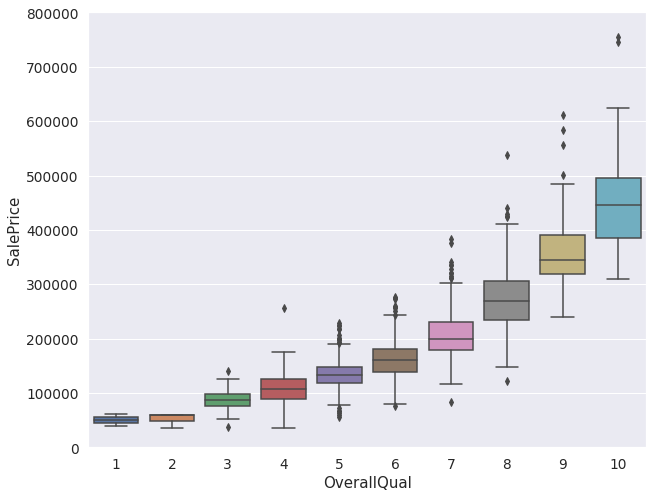

In [13]:
# box plot overallqual/saleprice
var = 'OverallQual'
tmp = pd.concat([data['SalePrice'], data[var]], axis=1)
f, ax = plt.subplots(figsize=(10, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=tmp)
fig.axis(ymin=0, ymax=800000)
plt.show()

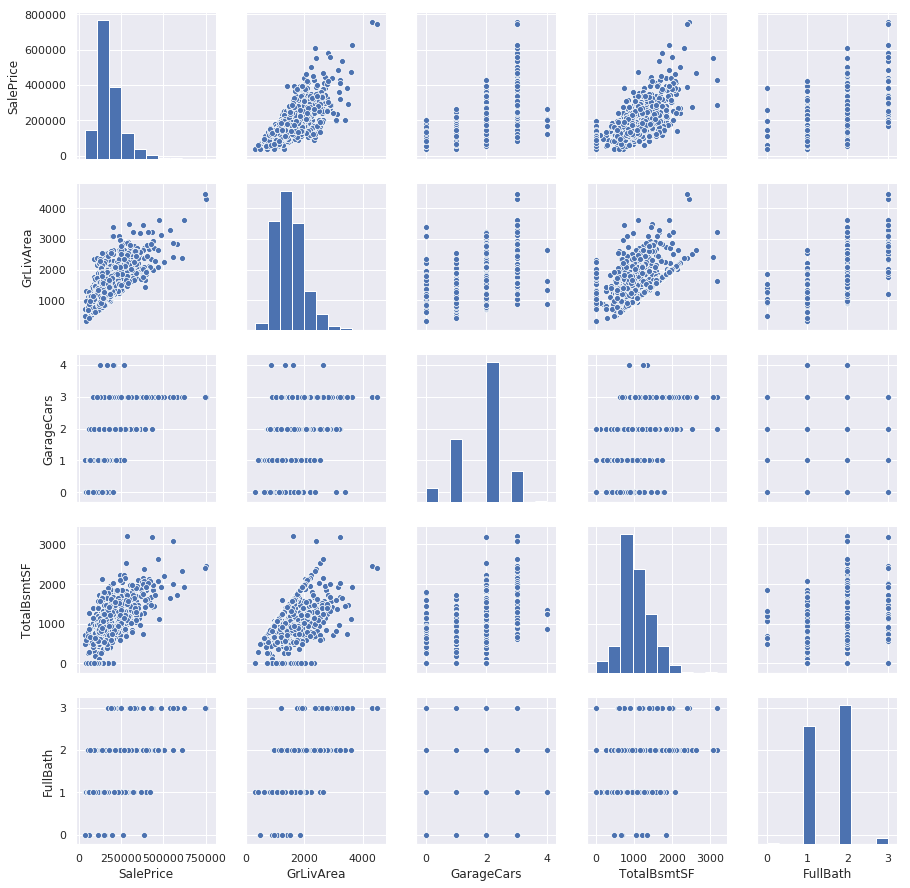

In [14]:
# scatterplot
sns.set()
cols = ['SalePrice', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath']
sns.pairplot(data[cols], height = 2.5)
plt.show()

In [15]:
def revert(x):
    return np.exp(x) - 1

In [16]:
# keeping only the features that we want to regress
data['SalePrice'] = tmp_log
train_features = data[['GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath']]
train_labels = data[['SalePrice']]
train_features.head()

#fixme do manually
X_train, X_test , y_train, y_test = train_test_split(train_features, train_labels, train_size = 0.8)

# Modeling

### Some features of matrix differentiations

#### Rule 1

$$ \alpha = a^{T}x $$
$$ a \rightarrow m x 1 $$
$$ x \rightarrow m x 1 $$
$$ $$
$$ \frac{d{x^{T}a}}{dx} =  \frac{d{a^{T}x}}{dx} = a^{T}  $$

#### Rule 2

$$ \alpha = x^{T}Ax^{T} $$
$$ x \rightarrow mx1 $$
$$ A \rightarrow mxm $$
$$ $$
$$ \frac{d\alpha}{dx} = x^{T}(A + A^{T}) $$

#### Loss function

$$  Loss = y^{T}y -2a^{T}X^{T}y + a^{T}X^{T}Xa  $$

#### OLS parameters

$$a = (X^{T}X)^{-1}X^{T}y $$


In [17]:
class MultipleLinearRegression:
    """Class for multiple linear regression representation."""
    
    def __init__(self):
        self.parameters = None
        
    def fit(self, X: np.matrix, Y: np.matrix):
        """Function for calculating parameters on sample data.
        n - number of data points
        m - number of features
        
        :param X: n x m - 1 dimmensional matrix of features.
        :param Y: n x 1 dimmensional matrix of response variable.
        
        """
        X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
        self.parameters = np.dot(np.dot(X.T, X).I, np.dot(X.T, Y))
        
    def predict(self, X: np.matrix):
        """Function for predicting response variable with fitted parameters.
        n - number of data points
        m - number of features
        
        :param X: n x m dimmensional matrix of features.
        """
        X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
        Y_pred = np.dot(X, self.parameters)
        return Y_pred

In [18]:
model = MultipleLinearRegression()
print(f'Initial parameters: {model.parameters}')
model.fit(np.matrix(X_train), np.matrix(y_train))
print(f'After fitting: {model.parameters}')

Initial parameters: None
After fitting: [[1.08521972e+01]
 [2.99171024e-04]
 [1.55134991e-01]
 [3.07219747e-04]
 [7.84543559e-02]]


# Evaluation

### Evaluation on Train data

The R square statistic provides an alternative measure of fit. It takes the form of a proportion—the proportion of variance explained—and so it always takes on a value between 0 and 1, and is independent of the scale of Y.

In [19]:
y_train_pred = model.predict(np.matrix(X_train))
r_2_train = r2_score(revert(y_train), revert(y_train_pred))

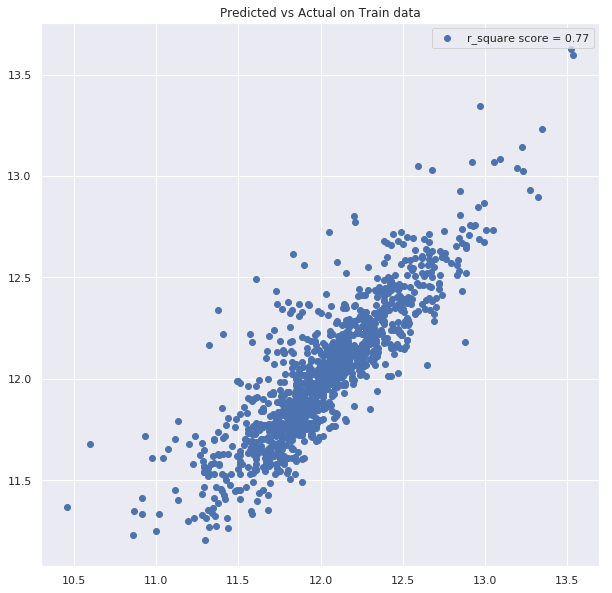

In [20]:
plt.figure(figsize=(10, 10))
plt.scatter(y_train.values.ravel(), np.array(y_train_pred))
plt.title('Predicted vs Actual on Train data')
plt.legend(['r_square score = {:.2f}'.format(r_2_train)], loc='best')
plt.show()

### Evaluation on Test data

In [21]:
y_test_pred = model.predict(np.matrix(X_test))
r_2_test = r2_score(revert(y_test), revert(y_test_pred))

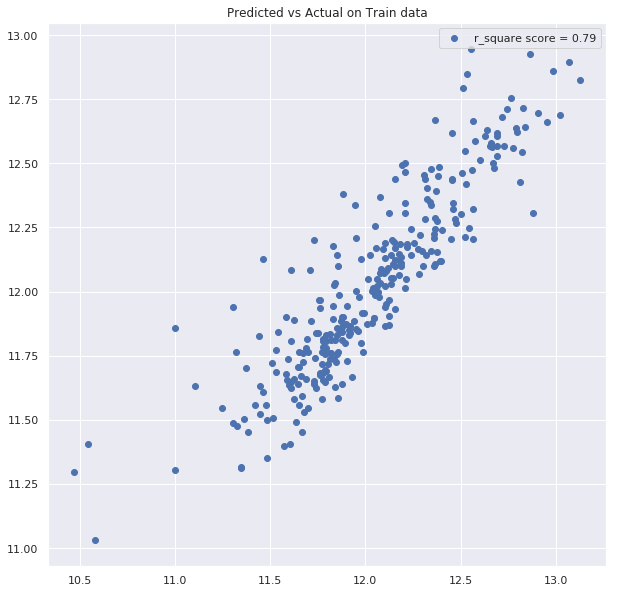

In [22]:
plt.figure(figsize=(10, 10))
plt.scatter(y_test.values.ravel(), np.array(y_test_pred))
plt.title('Predicted vs Actual on Train data')
plt.legend(['r_square score = {:.2f}'.format(r_2_test)], loc='best')
plt.show()

## Overfitting

Overfitting a model is a condition where a statistical model begins to describe the random error in the data rather than the relationships between variables.

I’d really like these problems to sink in because overfitting often occurs when analysts chase a high R-squared. In fact, inflated R-squared values are a symptom of overfit models! 

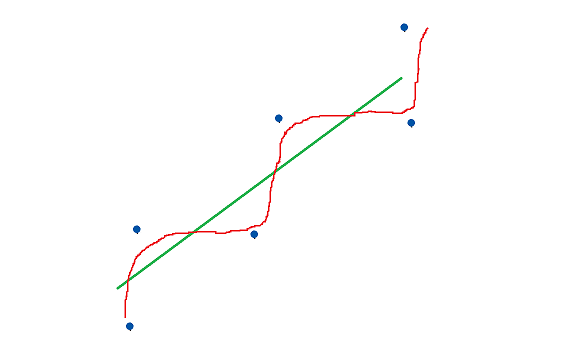

In [23]:
from IPython.display import Image
Image("img/overfit.png")

###  Lasso Regression

$$  Loss = y^{T}y -2a^{T}X^{T}y + a^{T}X^{T}Xa + \lambda |a|  $$

In [24]:
from sklearn.linear_model import Lasso, Ridge

In [25]:
model = Lasso()

In [26]:
model.fit(X_train, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

### Evaluation on Train data

In [27]:
y_train_pred = model.predict(np.matrix(X_train))
r_2_train = r2_score(revert(y_train), revert(y_train_pred))

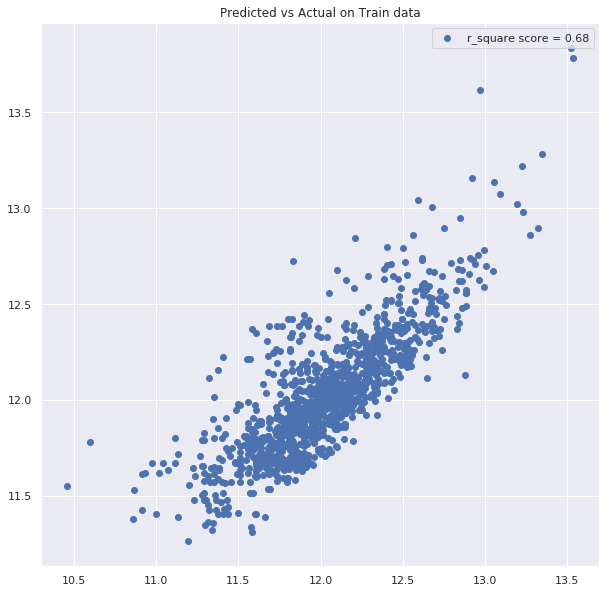

In [28]:
plt.figure(figsize=(10, 10))
plt.scatter(y_train.values.ravel(), np.array(y_train_pred))
plt.title('Lasso: Predicted vs Actual on Train data')
plt.legend(['r_square score = {:.2f}'.format(r_2_train)], loc='best')
plt.show()

### Evaluation on Test data

In [29]:
y_test_pred = model.predict(np.matrix(X_test))
r_2_test = r2_score(revert(y_test), revert(y_test_pred))

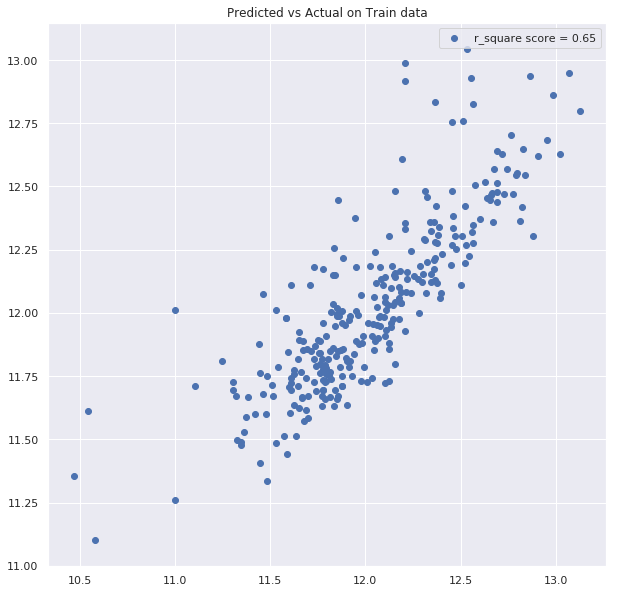

In [30]:
plt.figure(figsize=(10, 10))
plt.scatter(y_test.values.ravel(), np.array(y_test_pred))
plt.title('Lasso: Predicted vs Actual on Test data')
plt.legend(['r_square score = {:.2f}'.format(r_2_test)], loc='best')
plt.show()

### Ridge Regression

$$  Loss = y^{T}y -2a^{T}X^{T}y + a^{T}X^{T}Xa + \lambda a^{T}a  $$

In [31]:
model = Ridge()

In [32]:
model.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

### Evaluation on Train data

In [33]:
y_train_pred = model.predict(np.matrix(X_train))
r_2_train = r2_score(revert(y_train), revert(y_train_pred))

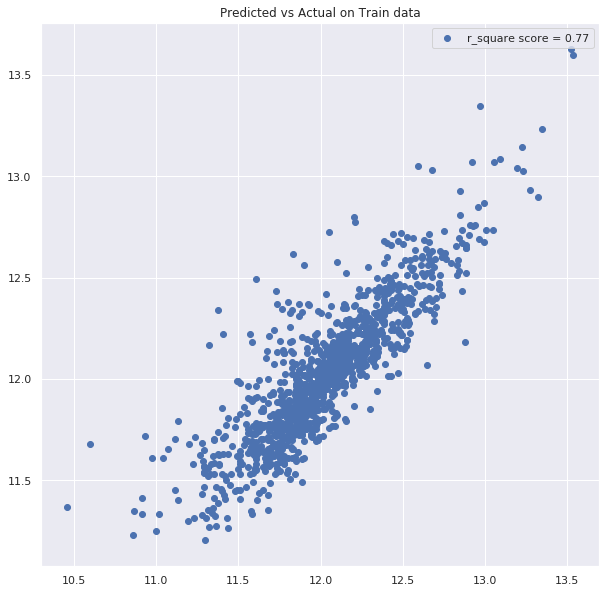

In [34]:
plt.figure(figsize=(10, 10))
plt.scatter(y_train.values.ravel(), np.array(y_train_pred))
plt.title('Ridge: Predicted vs Actual on Train data')
plt.legend(['r_square score = {:.2f}'.format(r_2_train)], loc='best')
plt.show()

### Evaluation on Test data

In [35]:
y_test_pred = model.predict(np.matrix(X_test))
r_2_test = r2_score(revert(y_test), revert(y_test_pred))

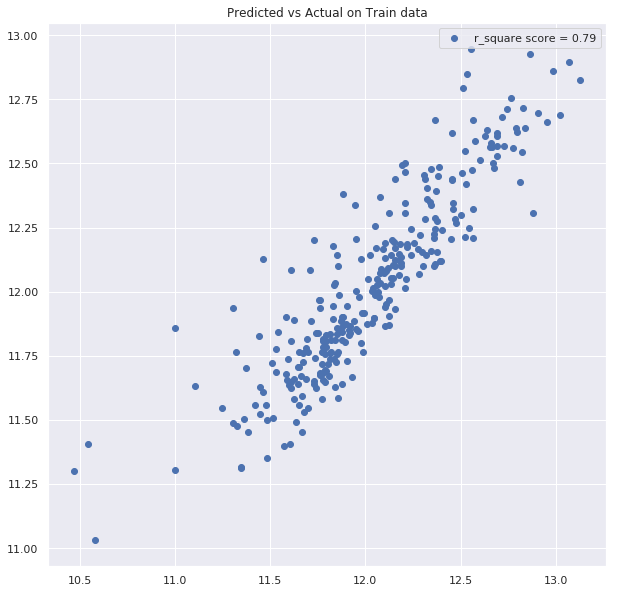

In [36]:
plt.figure(figsize=(10, 10))
plt.scatter(y_test.values.ravel(), np.array(y_test_pred))
plt.title('Ridge: Predicted vs Actual on Test data')
plt.legend(['r_square score = {:.2f}'.format(r_2_test)], loc='best')
plt.show()